<a href="https://colab.research.google.com/github/Thom204/OH202501/blob/main/OH_Taller_2_Solucion_de_modelos_con_Pyomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solución Taller 2 Optimización Heurística
## Integrantes
- Samuel Palomino Restrepo
- Maria Paulina Pupo Marin
- Thomas Monnier Granda
- Susana Silva Vallejo
- Sebastian Cepeda Jaimes



## Instalar las dependencias necesarias


In [1]:
#Instalar pyomo - cada vez que se use colab
!pip install -q pyomo

#Instalar un solver (solucionador) - GLPK (PL y PEM)
!apt-get install -y -qq glpk-utils

#Instalar el solver ipopt (PNL)
import matplotlib.pyplot as plt
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

#Importar el módulo pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

# Punto 2.

## Caso general (Nodos dados, pesos aleatorios).

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
'''TSP generalizado en pyomo usando distancias aleatorias del grafo
'''
def entrada_rule(model, j):
    return sum(model.x[i, j] for i in model.N if i != j) == 1


def salida_rule(model, i):
    return sum(model.x[i, j] for j in model.N if j != i) == 1


# Restricciones MTZ para evitar subciclos
def mtz_rule(model, i, j):
    if i != 0 and j != 0 and i != j:
        return model.u[i] - model.u[j] + \
            len(model.N) * model.x[i, j] <= len(model.N) - 1
    return Constraint.Skip


model0 = ConcreteModel()

# Definir los nodos del grafo
model0.N = Set(initialize=range(0, int(input("ingrese cantidad de nodos: "))))

model0.A = Set(dimen=2, initialize=[
    (i, j) for i in model0.N for j in model0.N if i != j
])

rng= np.random.default_rng(seed = 1038866661)

costos0 = {
    (i, j): rng.integers(low = 1, high = 100, size = 1)[0] for (i, j) in model0.A
}

model0.c = Param(model0.A, initialize=costos0)
model0.x = Var(model0.A, domain=Binary)

model0.obj= Objective(
    expr=sum(model0.c[i, j] * model0.x[i, j] for (i, j) in model0.A),
    sense=minimize
)

model0.salida = Constraint(model0.N, rule=salida_rule)
model0.entrada = Constraint(model0.N, rule=entrada_rule)

ingrese cantidad de nodos: 50


### Eliminacion de ciclos usando Miller Tucker Zemlin (MTZ No usar junto con el otro criterio)

In [18]:
model0.u = Var(model0.N, bounds=(0, len(model0.N)-1))
#Variable auxiliar u de orden forzado.

model0.mtz = Constraint(model0.A, rule=mtz_rule)

### Solución del modelo

In [23]:
# Crear el solver
solver = SolverFactory('glpk')  # Puedes cambiar a 'cbc' o 'gurobi' si tienes

# Resolver el modelo
results = solver.solve(model0)

# Mostrar la solución óptima
print("=== Solución Óptima del TSP ===")

# Reunir los pares de viajes según las variables diferentes a 0
ruta_dict = {
    i: j for (i, j) in model0.A if value(model0.x[i, j]) > 0.5
}

# Iniciar la ruta desde el nodo 0
nodo_inicio = 0
nodo_actual = nodo_inicio

# Lista para guardar la secuencia de nodos
ruta = [nodo_actual]

# Reconstruir la ruta siguiendo los saltos en el diccionario
while True:
    siguiente = ruta_dict[nodo_actual]
    ruta.append(siguiente)
    nodo_actual = siguiente
    if nodo_actual == nodo_inicio:
        break

# Imprimir la ruta óptima
print("=== Ruta Óptima ===")
print(" → ".join(str(n) for n in ruta))

# Mostrar el costo total
print(f"Costo total mínimo: {value(model0.obj)}")


=== Solución Óptima del TSP ===
=== Ruta Óptima ===
0 → 47 → 25 → 15 → 4 → 48 → 8 → 22 → 9 → 45 → 30 → 16 → 43 → 44 → 2 → 20 → 32 → 28 → 41 → 35 → 23 → 18 → 26 → 19 → 36 → 38 → 17 → 37 → 3 → 21 → 33 → 24 → 46 → 29 → 1 → 40 → 42 → 10 → 27 → 39 → 6 → 14 → 13 → 12 → 7 → 31 → 34 → 5 → 49 → 11 → 0
Costo total mínimo: 184.0


### Visualizacion del grafo (opcional)

0 → 47 → 25 → 15 → 4 → 48 → 8 → 22 → 9 → 45 → 30 → 16 → 43 → 44 → 2 → 20 → 32 → 28 → 41 → 35 → 23 → 18 → 26 → 19 → 36 → 38 → 17 → 37 → 3 → 21 → 33 → 24 → 46 → 29 → 1 → 40 → 42 → 10 → 27 → 39 → 6 → 14 → 13 → 12 → 7 → 31 → 34 → 5 → 49 → 11 → 0
Costo total mínimo: 184.0


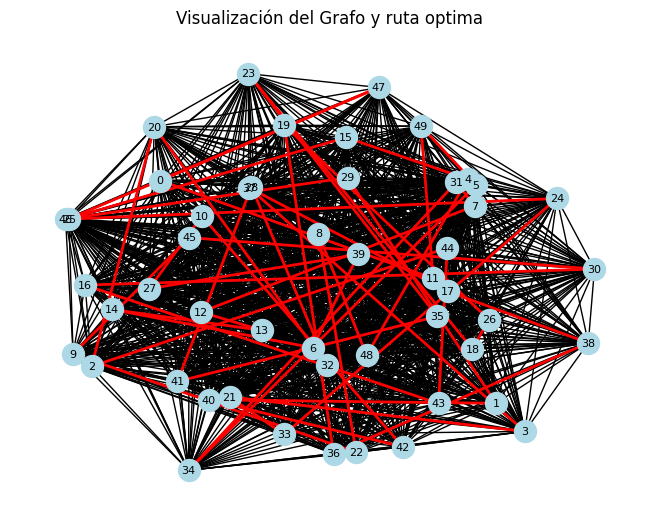

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

edges_to_highlight = [(i, j) for (i, j) in model0.A if value(model0.x[i, j]) > 0.5]
# Crear un grafo dirigido (o no dirigido si las distancias son simétricas)
G = nx.Graph()  # O usar nx.Graph() si no es dirigido

# Agregar aristas con pesos (distancias) al grafo
for (i, j), n in costos0.items():
    G.add_edge(i, j, weight=n)

# Dibujar el grafo
pos = nx.spring_layout(G)  # Define la disposición de los nodos
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=250, font_size=8)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size= 5, )
nx.draw_networkx_edges(G, pos, edgelist=edges_to_highlight, edge_color='red', width=2)

print(" → ".join(str(n) for n in ruta))
print(f"Costo total mínimo: {value(model0.obj)}")
plt.title("Visualización del Grafo y ruta optima")
plt.show()

## Caso especifico (5 nodos con pesos pre-definidos).

In [21]:
"""
Modelo del Problema del Viajante (TSP) usando Pyomo

Se minimiza el costo total de visitar todos los nodos exactamente una vez
y regresar al nodo de origen ('home'), con una matriz de costos simétrica.
"""

# Crear el modelo concreto
model = ConcreteModel()

# Definir los nodos del grafo (home = 0)
model.N = Set(initialize=[0, 1, 2, 3, 4])

# Crear conjunto de pares de nodos para aristas posibles (i ≠ j)
model.A = Set(dimen=2, initialize=[
    (i, j) for i in model.N for j in model.N if i != j
])

# Definir los costos (matriz simétrica)
costos = {
    (0, 1): 30, (0, 2): 50, (0, 3): 45, (0, 4): 80,
    (1, 0): 30, (1, 2): 25, (1, 3): 50, (1, 4): 50,
    (2, 0): 50, (2, 1): 25, (2, 3): 40, (2, 4): 40,
    (3, 0): 45, (3, 1): 50, (3, 2): 40, (3, 4): 35,
    (4, 0): 80, (4, 1): 50, (4, 2): 40, (4, 3): 35,
}

# Definir el parámetro de costos
model.c = Param(model.A, initialize=costos)

# Variable binaria: 1 si se viaja de i a j, 0 en caso contrario
model.x = Var(model.A, domain=Binary)

# Variables auxiliares para eliminación de subciclos (método MTZ)
model.u = Var(model.N, bounds=(0, len(model.N)-1))

# Función objetivo: minimizar el costo total del recorrido
model.obj = Objective(
    expr=sum(model.c[i, j] * model.x[i, j] for (i, j) in model.A),
    sense=minimize
)

model.salida = Constraint(model.N, rule=salida_rule)

model.entrada = Constraint(model.N, rule=entrada_rule)

model.mtz = Constraint(model.A, rule=mtz_rule)

# Crear el solver
solver = SolverFactory('glpk')  # Puedes cambiar a 'cbc' o 'gurobi' si tienes

# Resolver el modelo
results = solver.solve(model)

# Mostrar la solución óptima
print("=== Solución Óptima del TSP ===")

# Reunir los pares de viajes según las variables diferentes a 0
ruta_dict = {
    i: j for (i, j) in model.A if value(model.x[i, j]) > 0.5
}

# Iniciar la ruta desde el nodo 0
nodo_inicio = 0
nodo_actual = nodo_inicio

# Lista para guardar la secuencia de nodos
ruta = [nodo_actual]

# Reconstruir la ruta siguiendo los saltos en el diccionario
while True:
    siguiente = ruta_dict[nodo_actual]
    ruta.append(siguiente)
    nodo_actual = siguiente
    if nodo_actual == nodo_inicio:
        break

# Imprimir la ruta óptima
print("=== Ruta Óptima ===")
print(" → ".join(str(n) for n in ruta))

# Mostrar el costo total
print(f"Costo total mínimo: {value(model.obj)}")


=== Solución Óptima del TSP ===
=== Ruta Óptima ===
0 → 3 → 4 → 2 → 1 → 0
Costo total mínimo: 175.0


# Punto 3

In [ ]:
"""
Script de optimización de volumen de un prisma rectangular utilizando Pyomo
y el solucionador IPOPT.

Se busca maximizar el volumen de una caja rectangular sujeta a restricciones
de perímetro, altura y dimensiones máximas.

"""

# Crear el modelo abstracto de Pyomo
model3 = AbstractModel()

# Definir la variable de decisión 'h' (altura de la caja)
# Dominio: número real positivo (sin cota superior explícita aquí)
model3.h = Var(bounds=(0.0, None))

# Definir la variable de decisión 'x' (largo de la base)
model3.x = Var(bounds=(0.0, None))

# Definir la variable de decisión 'y' (ancho de la base)
model3.y = Var(bounds=(0.0, None))

# Definir la función objetivo
# Objetivo: maximizar el volumen de la caja (x * y * h)
model3.obj = Objective(
    expr=model3.x * model3.y * model3.h,
    sense=maximize
)

# Definir la restricción del perímetro de la base más la altura
# Restricción: h + 2x + 2y ≤ 72
model3.Rest0 = Constraint(
    expr=model3.h + 2 * model3.x + 2 * model3.y <= 72
)

# Restricción: lado 'x' no debe superar los 42 cm
model3.Rest1 = Constraint(
    expr=model3.x <= 42
)

# Restricción: lado 'y' no debe superar los 42 cm
model3.Rest2 = Constraint(
    expr=model3.y <= 42
)

# Restricción: altura 'h' no debe superar los 42 cm
model3.Rest3 = Constraint(
    expr=model3.h <= 42
)

# Crear el solucionador utilizando IPOPT
# Se proporciona la ruta explícita del ejecutable (ej. en Google Colab)
opt = SolverFactory('ipopt', executable='/content/ipopt')

# Crear una instancia del modelo abstracto para resolverlo
instance = model3.create_instance()

# Ejecutar la resolución del modelo usando el solver definido
results = opt.solve(instance)

if (results.solver.termination_condition.name == 'optimal'):

    # Obtener el valor óptimo de la variable 'x' (largo)
    x_opt = instance.x()

    # Obtener el valor óptimo de la variable 'y' (ancho)
    y_opt = instance.y()

    # Obtener el valor óptimo de la variable 'h' (altura)
    h_opt = instance.h()

    # Calcular el volumen máximo alcanzado
    volumen_max = x_opt * y_opt * h_opt

    # Imprimir los resultados con formato y unidades
    print("==== RESULTADOS ÓPTIMOS ====")
    print(f"Largo (x): {x_opt:.2f} unidades")
    print(f"Ancho (y): {y_opt:.2f} unidades")
    print(f"Altura (h): {h_opt:.2f} unidades")
    print(f"Volumen máximo: {volumen_max:.2f} unidades cúbicas")

# En caso de que no se encuentre solución óptima
else:
    print("No se encontró una solución óptima.")

==== RESULTADOS ÓPTIMOS ====
Largo (x): 12.00 unidades
Ancho (y): 12.00 unidades
Altura (h): 24.00 unidades
Volumen máximo: 3456.00 unidades cúbicas
